In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"


from stuff import *
from utils import *
float_formatter = lambda x: "%.2e" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

from time import time

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


cond 450.7796355404354
cond 450.7796355404354
eta_x 0.0033010211788121616 alpha_x 0.9000078314455164 beta_x 1.1606982341195032e-05 tau_x 0.12489861119120503 sigma_x 0.03330449540932557
theta 0.9988957100524117 eta_y 1.4508727926493788e-06 alpha_y 0 beta_y 0.0012324219586937392 tau_y 0.6666666666666666 sigma_y 1
f_star 6.9652236849577065

time APDG: 0.272763729095459

cond 450.7796355404354
Dual problem params: L=14499602.000246763, mu=4095.3899304615625, L/mu=3540.4692218434534
globally dual stepsize: 6.896741027670838e-08, momentum: 0.9669431553122092
f_star 6.9652236849577065 err init 25.220090265389288

time GDAM: 1.374394416809082

Dual problem params: L=12638837.87609846, mu=12306.07327034541, L/mu=1027.0406813321133
locally dual stepsize: 7.912119846802676e-08, momentum: 0.9394810050064234
f_star 6.9652236849577065

time LDAM: 0.9604008197784424



Text(0.5, 0, 'Iteration number')

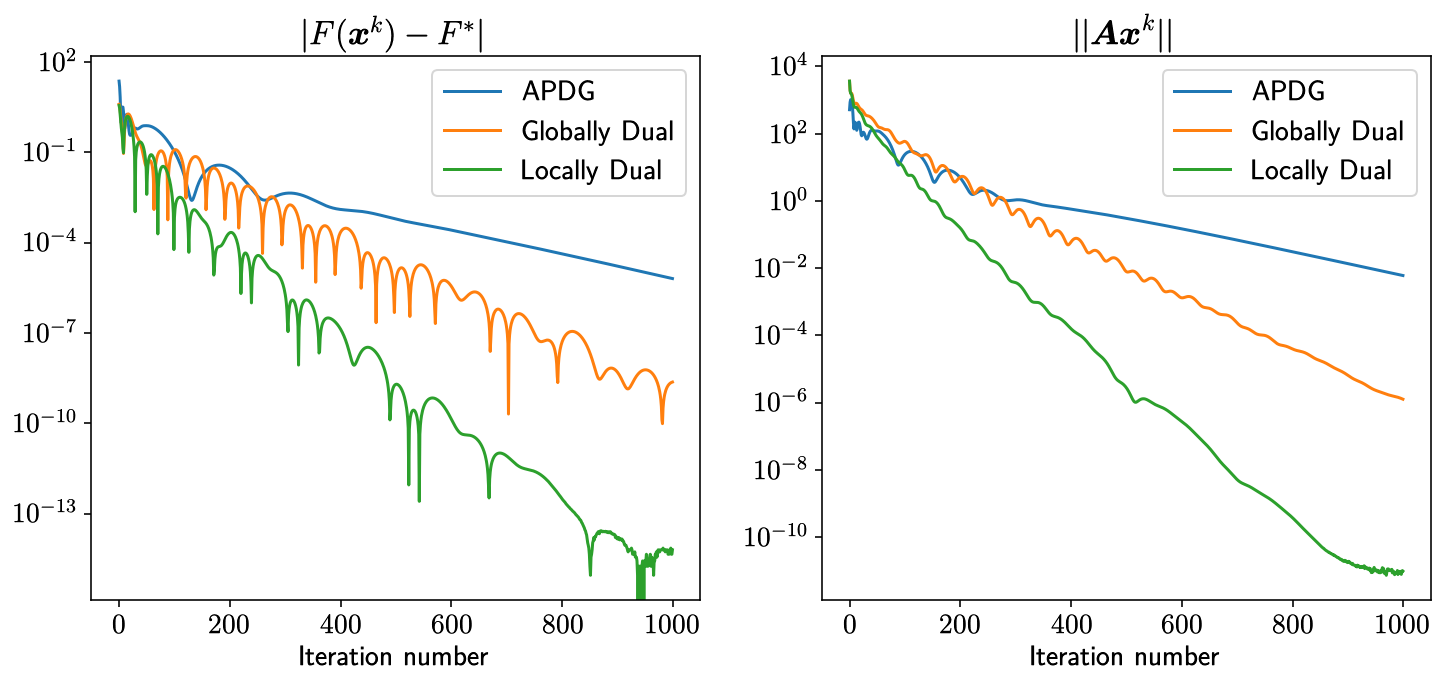

In [2]:
iters = 1000
np.random.seed(42)
plt.figure(figsize=(12,5))

model_params = dict(nodes=5, dim=40, B_rank=1)#, graph="erdos-renyi", edge_prob=0.3)
model = Model(**model_params)

mu_x, mu_xy, L_x, L_xy = model.get_mu_L()

t_start = time()
x_res, f_err, cons_err = APDG(iters, model)
print(f"\ntime APDG: {time() - t_start}\n")

plt.subplot(121)
plt.plot(f_err, label='APDG')
plt.title('$|F(\\boldsymbol{x}^k) -F^*|$')
plt.yscale('log')

plt.subplot(122)
plt.plot(cons_err, label='APDG')
plt.title('$||\\boldsymbol{Ax}^k||$')
plt.yscale('log')

t_start = time()
x_res, f_err, cons_err = GDAM(iters, model)
print(f"\ntime GDAM: {time() - t_start}\n")

plt.subplot(121)
plt.plot(f_err, label='Globally Dual')
plt.legend()

plt.subplot(122)
plt.plot(cons_err, label='Globally Dual')
plt.legend()

t_start = time()
x_res, f_err, cons_err = LDAM(iters, model)
print(f"\ntime LDAM: {time() - t_start}\n")

plt.subplot(121)
plt.plot(f_err, label='Locally Dual')
plt.legend()
plt.xlabel('Iteration number')

plt.subplot(122)
plt.plot(cons_err, label='Locally Dual')
plt.legend()
plt.xlabel('Iteration number')

# plt.savefig("n10_d100.eps")

In [3]:
%%time
iters=4000
repeat = 10 
t_apdm, t_gdam, t_ldam = 0, 0, 0
it_apdm, it_gdam, it_ldam = 0, 0, 0
limit_apdm, limit_gdam, limit_ldam = 0, 0, 0

accuracy = 1e-2

for _ in range(repeat):
    model = Model(**model_params)
    t_start = time()
    x_res, f_err, cons_err = APDG(iters, model, use_crit=True, accuracy=accuracy)
    t_apdm += time() - t_start
    it = (f_err > 0).sum()  # error arrays initialized as np.zeros()
    it_apdm += it
    limit_apdm += (it >= iters)
    print("iters, ", it, "total excessions:", limit_apdm)
    if it >= iters:
        plt.plot(f_err, label="apdm" + str(_))
        plt.yscale("log")
        plt.legend()
        plt.show()
    
    t_start = time()
    x_res, f_err, cons_err = GDAM(iters, model, use_crit=True, accuracy=accuracy)
    t_gdam += time() - t_start
    it = (f_err > 0).sum()  # error arrays initialized as np.zeros()
    it_gdam += it
    limit_gdam += (it >= iters)
    print("iters, ", it, "total excessions:", limit_gdam)
    if it >= iters:
        plt.plot(f_err, label="gdam" + str(_))
        plt.yscale("log")
        plt.legend()
        plt.show()
    
    
    t_start = time()
    x_res, f_err, cons_err = LDAM(iters, model, use_crit=True, accuracy=accuracy)
    t_ldam += time() - t_start
    it = (f_err > 0).sum()  # error arrays initialized as np.zeros()
    it_ldam += it
    limit_ldam += (it >= iters)
    print("iters, ", it, "total excessions:", limit_ldam)
    if it >= iters:
        plt.plot(f_err, label="ldam" + str(_))
        plt.yscale("log")
        plt.legend()
        plt.show()
    
print(f"\ntime APDG (crit): {t_apdm / repeat}, iters: {it_apdm / repeat}, excessions: {limit_apdm}\n")  
print(f"\ntime GDAM (crit): {t_gdam / repeat}, iters: {it_gdam / repeat}, excessions: {limit_gdam}\n")
print(f"\ntime LDAM (crit): {t_ldam / repeat}, iters: {it_ldam / repeat}, excessions: {limit_ldam}\n")


cond 459.2460457175584
eta_x 0.003270179838042938 alpha_x 0.9000826573019038 beta_x 1.2419187237369539e-05 tau_x 0.12381357787989351 sigma_x 0.03299607555521671
theta 0.9989159798666194 eta_y 1.5523984046711924e-06 alpha_y 0 beta_y 0.0012096011329772644 tau_y 0.6666666666666666 sigma_y 1
f_star 7.9836302988530825
iters,  973 total excessions: 0
cond 459.2460457175584
Dual problem params: L=13678006.290454308, mu=3792.1092286927906, L/mu=3606.965270662672
globally dual stepsize: 7.311007019333557e-08, momentum: 0.9672442680721348
f_star 7.9836302988530825 err init 26.034250223914416
iters,  514 total excessions: 0
Dual problem params: L=11933514.948963214, mu=13923.195126742754, L/mu=857.0960070826061
locally dual stepsize: 8.379760735011944e-08, momentum: 0.9339415163101148
f_star 7.9836302988530825
iters,  279 total excessions: 0
cond 456.5736599595794
eta_x 0.003279859460511705 alpha_x 0.9000488508314215 beta_x 7.314355517274251e-06 tau_x 0.12415293729298052 sigma_x 0.033092499852790

iters,  263 total excessions: 0

time APDG (crit): 0.2700292348861694, iters: 895.2, excessions: 0


time GDAM (crit): 0.6068808555603027, iters: 512.2, excessions: 0


time LDAM (crit): 0.3038653373718262, iters: 268.6, excessions: 0

CPU times: user 57.7 s, sys: 2min 6s, total: 3min 4s
Wall time: 12 s
